In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm


In [17]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'

# sex = 'chrXY'
# sex = 'chrX'
# sex = 'chrY'
# sex = 'autosome'

value_to_predict = 'Sex'

organ = "HEART"
sex= 'autosome'
# sex= 'chrY'


In [18]:

with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')


features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]


In [19]:
data_train = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)
data_train = data_train[features_list.index]


data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
data_train['sex'] = data_header['Sex']
data_train


,MSTRG.1913.3,ENST00000372476.8,MSTRG.1168.1,MSTRG.21565.12,MSTRG.13450.7,MSTRG.21565.11,MSTRG.17871.5,ENST00000300184.8,ENST00000413366.8,ENST00000246080.4,...,MSTRG.9702.3,ENST00000372987.8,MSTRG.6310.11,MSTRG.813.69,ENST00000392008.6,MSTRG.31035.16,ENST00000331581.11,ENST00000553708.5,ENST00000426395.7,sex
ERR188021,1.879362,0.371820,0.448089,0.000000,0.331404,0.346092,0.000000,0.693165,0.981270,0.777719,...,3.194446,0.544637,0.000000,2.395691,1.043788,0.473281,0.029700,0.000000,1.941098,F
ERR188022,0.561952,0.000000,0.343467,0.000000,0.312306,0.302993,0.000000,1.554989,0.036522,0.256587,...,0.000000,0.771966,0.002426,2.287521,0.701596,1.066574,1.410393,2.154291,0.052954,M
ERR188023,0.169051,0.524604,1.178407,1.471592,0.021934,0.929705,0.012570,0.813395,0.131450,0.397523,...,4.174785,0.000000,2.194881,0.048921,4.235678,1.427488,0.000000,0.796462,0.251772,F
ERR188024,1.068493,0.000000,1.179953,0.000000,0.000000,0.057898,0.000000,0.000000,0.169784,0.000000,...,4.057852,0.000000,0.608426,0.000000,0.173652,0.000000,1.602816,1.883474,1.990728,F
ERR188025,0.495171,0.000000,0.717738,0.000000,0.433328,1.369905,0.000000,0.161968,0.126303,1.538842,...,0.000000,0.224697,0.000000,0.127256,1.033112,0.566476,0.056117,0.000000,0.824826,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,0.000000,0.000000,2.946633,0.000000,1.121803,0.000000,0.000000,0.000000,3.185858,2.738430,...,0.000000,2.249973,0.442946,0.000000,0.000000,0.000000,3.180119,0.000000,0.000000,F
ERR205020,0.251156,1.593257,0.126522,0.000000,0.000000,0.279521,0.001527,0.636723,0.150324,0.736191,...,0.000000,0.230335,0.244719,0.247456,0.115513,0.888003,1.731710,0.321248,0.489444,M
ERR205021,0.761626,0.831338,0.595642,0.000000,1.535681,0.700445,0.000000,0.000000,3.015059,0.000000,...,1.602585,5.175067,0.030805,0.525416,0.146914,0.000000,0.147242,1.759293,0.777570,M
ERR205022,0.446839,1.753175,0.000000,0.000000,0.132270,0.074429,0.000000,0.000000,0.063528,0.593497,...,4.673975,0.000000,0.590139,2.201288,0.231242,1.226098,0.183334,1.001822,1.353977,F


In [20]:
X = data_eval.values
X = RobustScaler().fit_transform(X)

y = data_eval_header['sex'].values
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

label_encoder.classes_
# y = (dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values

array(['female', 'male'], dtype=object)

predicted:    [0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]
--------------------
mean_auc=0.3828282828282828,
mean_accuracy=0.5,
mean_f1=0.3555555555555555,
mean_precision=0.4222222222222222,
mean_recall=0.31111111111111106,
--------------------
```


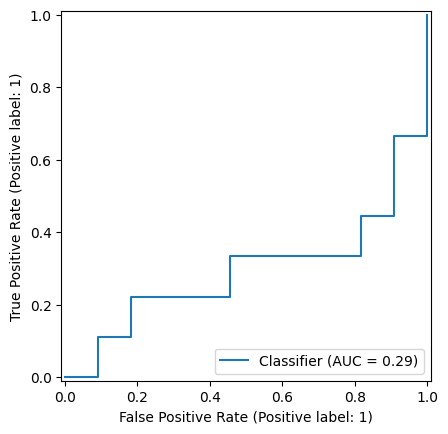

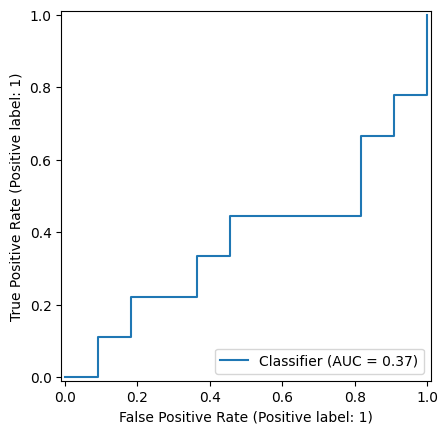

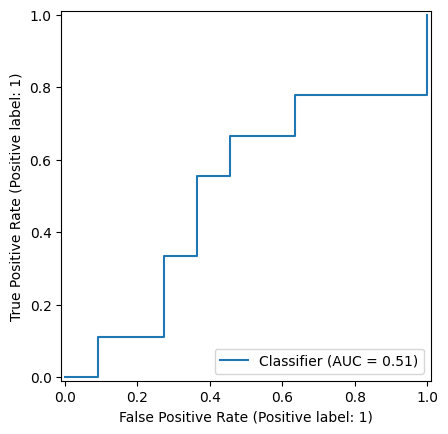

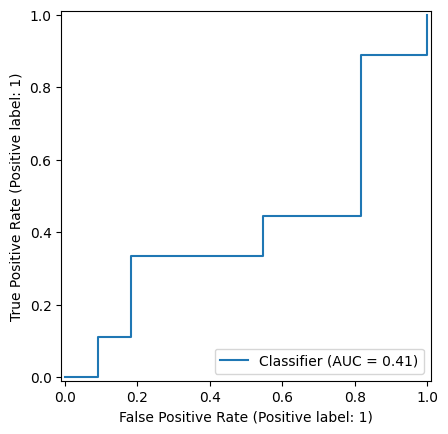

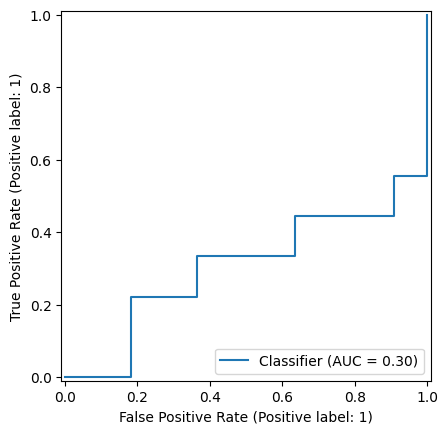

In [21]:
proba = np.zeros(shape=(X.shape[0], 2))
pred = np.zeros(shape=(X.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(5):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X)
    pred_ = model.predict(X)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y, pred_))
    f1.append(f1_score(y, pred_))
    precisions.append(precision_score(y, pred_))
    recalls.append(recall_score(y, pred_))

    viz = RocCurveDisplay.from_predictions(
        y, model.predict_proba(X)[:, 1],
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)

proba = proba / 5
# pred = pred / 5
print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

In [22]:
proba[:, 1]

array([0.27220809, 0.13716225, 0.23862787, 0.59021615, 0.53947833,
       0.31351734, 0.81949002, 0.18318942, 0.18252071, 0.92370017,
       0.1866321 , 0.1826291 , 0.05446743, 0.01075386, 0.10581322,
       0.84451603, 0.65481769, 0.39736112, 0.10425968, 0.49408552])

In [23]:
# data_eval_header
test_header = data_eval_header.copy(deep=True)
# test_header['test_prediction'] = (proba[:, 1] > 0.5).astype(int)
test_header['sex_prediction'] = pred/5
test_header['sex_proba'] = proba[:, 1]

# test_header['sex']
features_list

,SHAP
MSTRG.1913.3,50
ENST00000372476.8,50
MSTRG.1168.1,49
MSTRG.21565.12,49
MSTRG.13450.7,47
...,...
ENST00000392008.6,15
MSTRG.31035.16,15
ENST00000331581.11,15
ENST00000553708.5,15


In [24]:
dataset = test_header[['cardiac_chamber', 'sex_prediction', 'sex_proba', 'sex']]
dataset

,cardiac_chamber,sex_prediction,sex_proba,sex
0,Right ventricle,0.0,0.272208,female
1,Left ventricle,0.0,0.137162,female
2,Right atrium,0.2,0.238628,female
3,Left atrium,0.8,0.590216,female
4,Right atrium,0.6,0.539478,female
5,Right ventricle,0.2,0.313517,female
6,Left atrium,1.0,0.819490,female
7,Right ventricle,0.0,0.183189,female
8,Left ventricle,0.0,0.182521,female
9,Right atrium,1.0,0.923700,female


In [25]:
(dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values


dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Right ", "")
dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Left ", "")
# dataset

/tmp/ipykernel_69443/1602482625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Right ", "")
/tmp/ipykernel_69443/1602482625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Left ", "")


(0.0, 1.0)

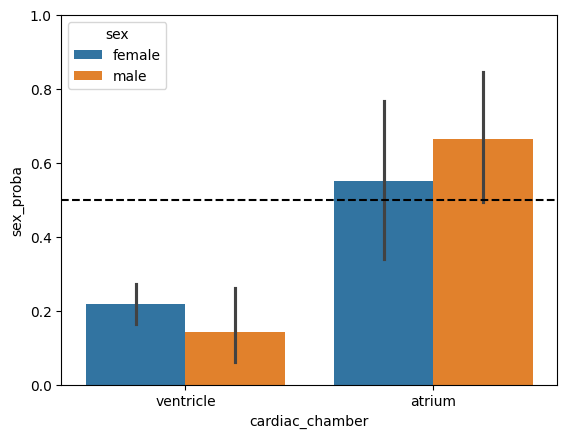

In [26]:
# g = sns.barplot(dataset, x='cardiac_chamber', y='sex_prediction', hue='sex')
g = sns.barplot(dataset, x='cardiac_chamber', y='sex_proba', hue='sex')
g.axhline(0.5, color='black', linestyle='dashed')
g.set_ylim([0, 1])

# plt.hlines(0.5, 0, 1)

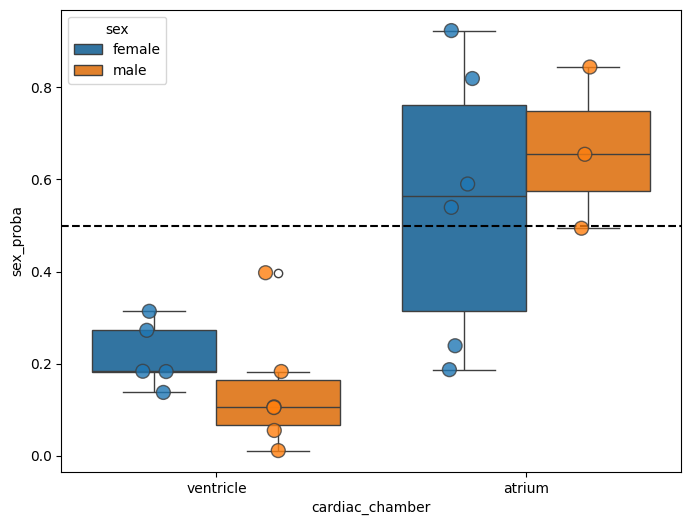

In [27]:
f, ax = plt.subplots(figsize=(8, 6))
# g =  sns.stripplot(dataset, x='cardiac_chamber', y='sex_prediction', hue='sex', size=10)
sns.boxplot(dataset, x='cardiac_chamber', y='sex_proba', hue='sex')
sns.stripplot(dataset, x='cardiac_chamber', y='sex_proba', hue='sex', size=10, dodge=True, linewidth=1, alpha=0.8,
              legend=False)
ax.axhline(0.5, color='black', linestyle='dashed')
# g.axhline(0.5, color='black', linestyle='dashed')
# g.set_ylim([0, 1])


In [28]:
data_research = data_eval.copy(deep=True)

dataset.set_index(data_research.index, inplace=True)
data_research['cardiac_chamber'] = dataset['cardiac_chamber']


In [14]:
data_train_scaled = RobustScaler().fit_transform(data_train.drop(columns='sex'))
data_train_scaled = pd.DataFrame(data=data_train_scaled, columns=data_train.drop(columns='sex').columns, index=data_train.index)
data_train_scaled['sex'] = data_train['sex']
# data_train_scaled

data_research_scaled = RobustScaler().fit_transform(data_research.drop(columns='cardiac_chamber'))
data_research_scaled = pd.DataFrame(data=data_research_scaled, columns=data_research.drop(columns='cardiac_chamber').columns, index=data_research.index)
data_research_scaled['cardiac_chamber'] = data_research['cardiac_chamber']
data_research_scaled['sex'] = dataset['sex']


In [89]:
from scipy.stats import wasserstein_distance

# data_research_scaled.drop(columns='sex').melt('cardiac_chamber')
# data_research_scaled.drop(columns='cardiac_chamber').melt('sex')
# data_train_scaled.melt("sex")


# data_research_scaled.drop(columns='sex')[['ENST00000372476.8', 'cardiac_chamber']].groupby('cardiac_chamber')

distr1 = list(data_research_scaled.drop(columns='sex').groupby('cardiac_chamber'))[0][1]
distr2 = list(data_research_scaled.drop(columns='sex').groupby('cardiac_chamber'))[1][1]
differences1 = distr2.drop(columns='cardiac_chamber').median() - distr1.drop(columns='cardiac_chamber').median()

distr1 = list(data_research_scaled.drop(columns='cardiac_chamber').groupby('sex'))[0][1]
distr2 = list(data_research_scaled.drop(columns='cardiac_chamber').groupby('sex'))[1][1]
differences2 = distr1.drop(columns='sex').median() - distr2.drop(columns='sex').median()

# distr1 = list(data_research_scaled.drop(columns='sex').groupby('cardiac_chamber'))[0][1]
# distr2 = list(data_research_scaled.drop(columns='sex').groupby('cardiac_chamber'))[1][1]
# differences3 = distr1.drop(columns='cardiac_chamber').mean() - distr2.drop(columns='cardiac_chamber').mean()


distr1 = list(data_train_scaled.groupby('sex'))[0][1]
distr2 = list(data_train_scaled.groupby('sex'))[1][1]
differences3 = distr1.drop(columns='sex').median() - distr2.drop(columns='sex').median()
differences3

(differences1 - differences2).sort_values().index
# differences1 - differences3

Index(['ENST00000371225.4', 'ENST00000300184.8', 'ENST00000303115.8',
       'ENST00000368680.4', 'ENST00000554383.5', 'MSTRG.3806.9',
       'ENST00000390331.3', 'ENST00000337338.9', 'ENST00000602741.1',
       'MSTRG.8485.2', 'MSTRG.21300.10', 'MSTRG.1913.3', 'ENST00000548200.5',
       'MSTRG.4428.2', 'MSTRG.27773.6', 'ENST00000521155.5',
       'ENST00000565196.5', 'ENST00000645860.1', 'MSTRG.5179.5',
       'MSTRG.813.69', 'MSTRG.9085.27', 'MSTRG.13900.12', 'ENST00000426395.7',
       'MSTRG.26990.1', 'MSTRG.31758.3', 'MSTRG.1168.1', 'ENST00000651342.1',
       'ENST00000372987.8', 'ENST00000589005.5', 'ENST00000587012.1',
       'ENST00000441002.1', 'ENST00000367718.5', 'ENST00000372476.8',
       'MSTRG.6310.11', 'MSTRG.1692.7', 'ENST00000472755.2', 'MSTRG.26895.13',
       'MSTRG.21565.12', 'MSTRG.13450.7', 'MSTRG.14482.3', 'MSTRG.20714.15',
       'ENST00000464587.2', 'ENST00000372583.6', 'ENST00000331581.11',
       'ENST00000543072.2', 'MSTRG.26509.13', 'MSTRG.28032.1', 'MST

[]

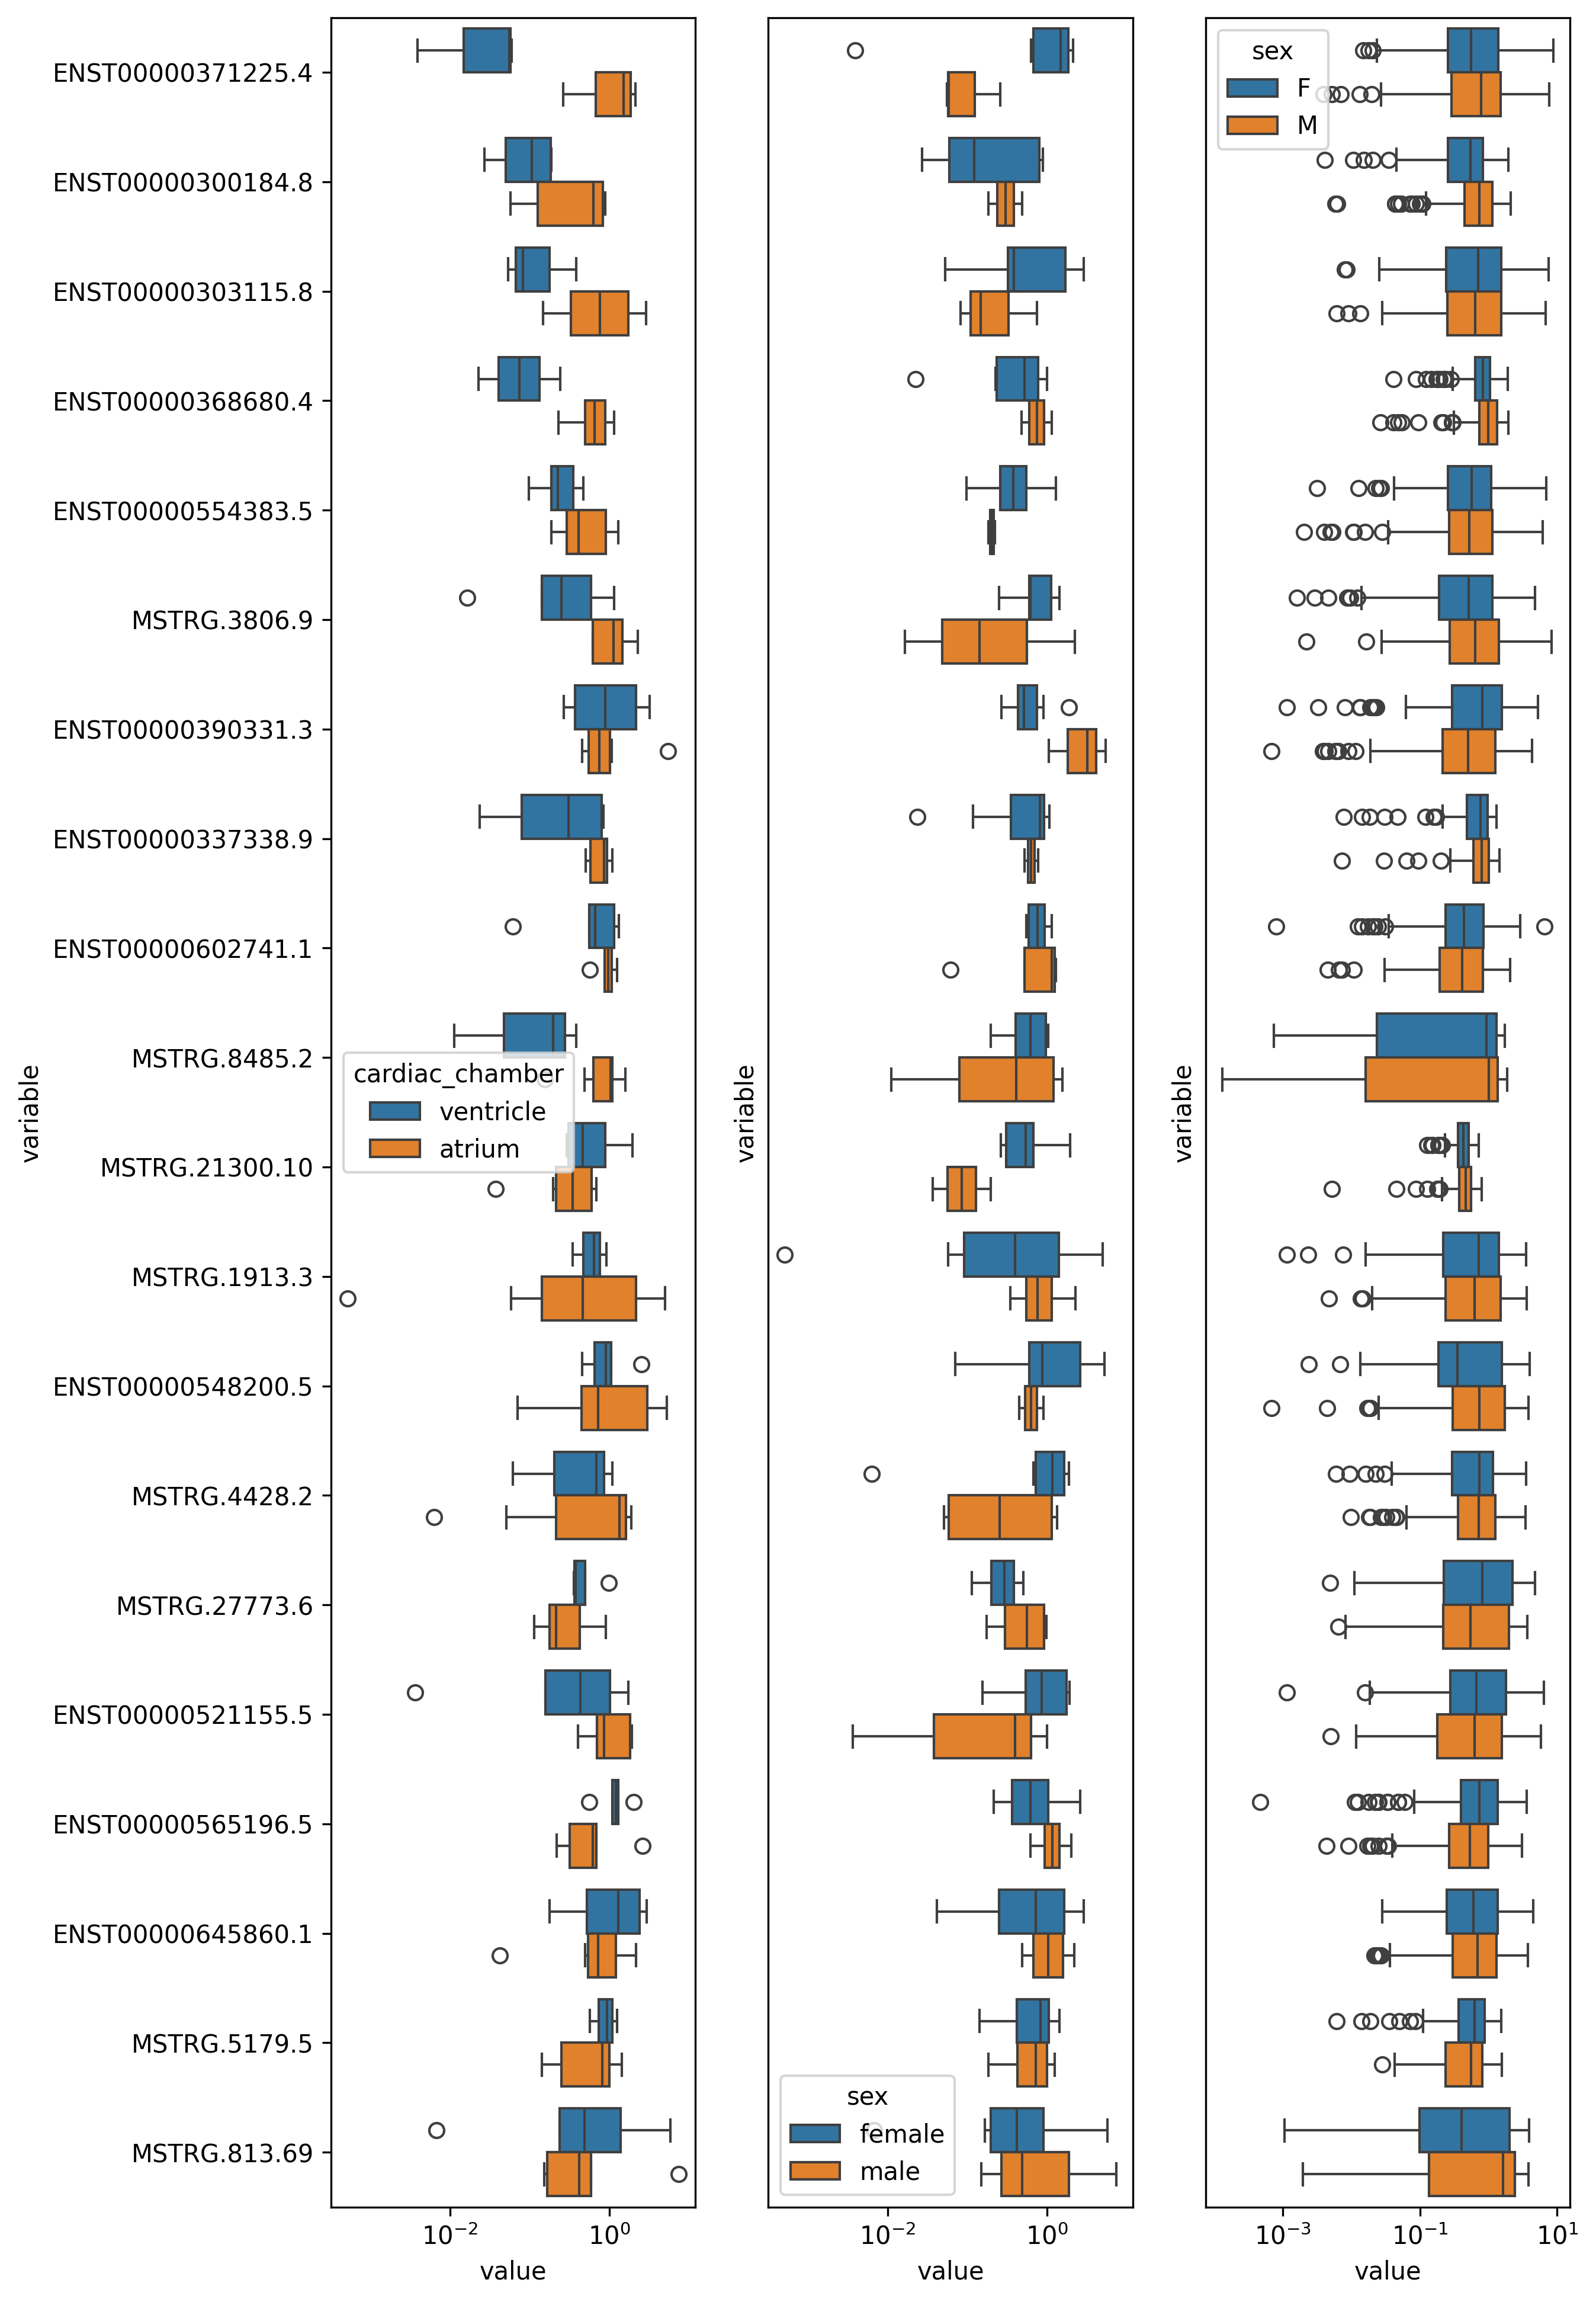

In [96]:
fig, axs = plt.subplots(figsize=(9, 16), ncols=3, dpi=300)
sns.boxplot(data=data_research_scaled.drop(columns='sex').melt('cardiac_chamber'), x='value', y="variable", hue='cardiac_chamber', log_scale=True,
            ax=axs[0], order=(differences1 - differences2).sort_values().index[:20])
sns.boxplot(data=data_research_scaled.drop(columns='cardiac_chamber').melt('sex'), x='value', y="variable", hue='sex', log_scale=True,
            ax=axs[1], order=(differences1 - differences2).sort_values().index[:20])

sns.boxplot(data=data_train_scaled.melt("sex"), x='value', y="variable", hue='sex', log_scale=True,
            ax=axs[2], order=(differences1 - differences2).sort_values().index[:20])

axs[1].set_yticks([])
axs[2].set_yticks([])

ENST00000372476.8     0.268213
MSTRG.1913.3         -0.266457
MSTRG.21565.12       -0.601639
MSTRG.1168.1          0.011052
MSTRG.13450.7        -0.293167
                        ...   
ENST00000392008.6    -0.074113
MSTRG.31035.16       -0.254866
ENST00000331581.11    0.154340
ENST00000553708.5    -0.167260
ENST00000426395.7     0.118420
Length: 82, dtype: float32

Index(['ENST00000371225.4', 'ENST00000300184.8', 'ENST00000303115.8',
       'ENST00000368680.4', 'ENST00000554383.5', 'MSTRG.3806.9',
       'ENST00000390331.3', 'ENST00000337338.9', 'ENST00000602741.1',
       'MSTRG.8485.2', 'MSTRG.21300.10', 'MSTRG.1913.3', 'ENST00000548200.5',
       'MSTRG.4428.2', 'MSTRG.27773.6', 'ENST00000521155.5',
       'ENST00000565196.5', 'ENST00000645860.1', 'MSTRG.5179.5',
       'MSTRG.813.69', 'MSTRG.9085.27', 'MSTRG.13900.12', 'ENST00000426395.7',
       'MSTRG.26990.1', 'MSTRG.31758.3', 'MSTRG.1168.1', 'ENST00000651342.1',
       'ENST00000372987.8', 'ENST00000589005.5', 'ENST00000587012.1',
       'ENST00000441002.1', 'ENST00000367718.5', 'ENST00000372476.8',
       'MSTRG.6310.11', 'MSTRG.1692.7', 'ENST00000472755.2', 'MSTRG.26895.13',
       'MSTRG.21565.12', 'MSTRG.13450.7', 'MSTRG.14482.3', 'MSTRG.20714.15',
       'ENST00000464587.2', 'ENST00000372583.6', 'ENST00000331581.11',
       'ENST00000543072.2', 'MSTRG.26509.13', 'MSTRG.28032.1', 'MST

,ENST00000372476.8,MSTRG.1913.3,MSTRG.21565.12,MSTRG.1168.1,MSTRG.13450.7,MSTRG.21565.11,MSTRG.17871.5,ENST00000300184.8,ENST00000413366.8,ENST00000246080.4,...,MSTRG.9702.3,ENST00000372987.8,MSTRG.6310.11,MSTRG.813.69,ENST00000392008.6,MSTRG.31035.16,ENST00000331581.11,ENST00000553708.5,ENST00000426395.7,cardiac_chamber
SRR21423854,-0.235356,-0.494477,-0.551157,1.011100,0.031564,-0.447193,0.681831,-0.027123,2.136907,-0.638688,...,0.795428,-0.582567,2.395336,0.235205,0.341168,0.775817,-0.065868,-0.868128,0.553179,ventricle
SRR21423855,0.570212,-0.494477,-0.865178,0.045251,0.009294,-1.009985,7.014357,-0.794047,2.045854,-0.312316,...,-0.258134,-0.954258,-0.038466,5.778645,0.122690,-0.084116,-0.065868,-0.502796,-0.489514,ventricle
SRR21423856,0.310489,0.058115,-0.865178,0.744040,0.271952,-0.551314,-0.068477,0.056832,1.233520,-0.253661,...,0.851466,0.212835,9.338378,0.418316,0.000632,-0.036046,7.593061,-0.272758,0.386897,atrium
SRR21423857,0.258603,5.000225,-0.865178,1.426295,1.180660,-0.696969,-0.615972,0.822765,0.909496,-0.465962,...,-0.258134,-0.142575,-0.125524,-0.788206,-0.377533,-0.564618,4.080417,0.670514,-0.878930,atrium
SRR21423858,-0.360754,0.461434,0.095633,0.482826,-1.022117,-1.009985,0.197733,0.884945,-0.499999,-2.056080,...,-0.258134,1.491082,0.124400,0.590638,-0.005439,-0.564618,-0.065868,-0.001740,1.144061,atrium
SRR21423859,0.986980,-0.494477,-0.865178,-0.045251,-0.501212,-1.009985,0.344737,0.060965,-0.283207,1.022714,...,-0.258134,-0.954258,-0.125524,-0.006770,-0.038277,1.324590,0.035551,1.976873,0.345455,ventricle
SRR21423860,0.806785,0.000515,0.306702,-0.155742,-0.950864,-1.009985,-0.654339,-0.088265,-0.571222,0.932921,...,-0.258134,0.637809,6.020460,-0.523436,-0.636967,-0.564618,0.004601,0.001740,-1.390590,atrium
SRR21423861,1.625268,-0.000515,0.744902,0.113938,-0.081841,0.563202,0.179425,0.183591,-0.115285,0.577304,...,0.258134,-0.352982,-0.067022,1.374908,-1.344557,-0.564618,-0.065868,-0.094381,0.146229,ventricle
SRR21423862,-0.135827,0.345674,0.090425,0.950494,-0.843934,0.294847,-0.733086,0.027123,0.047405,0.532964,...,0.730332,-0.203484,19.344051,0.006770,0.957568,-0.564618,0.100075,-0.266586,-0.114792,ventricle
SRR21423863,-0.016878,2.053413,0.930298,0.096113,0.194630,1.106067,-0.085535,0.803885,-0.047405,-0.408270,...,-0.258134,0.051061,-0.125524,0.165275,-0.000632,0.328678,-0.065868,-0.322533,0.114792,atrium


In [16]:
from sklearn.decomposition import PCA
import umap


<Axes: >

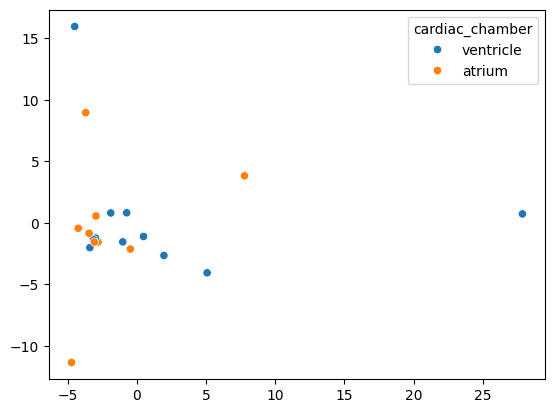

In [17]:
scaler = PCA(2)
# scaler = umap.UMAP(2)
scaler.fit(
    RobustScaler().fit_transform(data_research.drop(columns='cardiac_chamber').values)
    )
pca_eval = scaler.transform(
    RobustScaler().fit_transform(data_research.drop(columns='cardiac_chamber').values)
    )
sns.scatterplot(x=pca_eval[:,0], y=pca_eval[:,1], hue=data_research['cardiac_chamber'])



<Axes: >

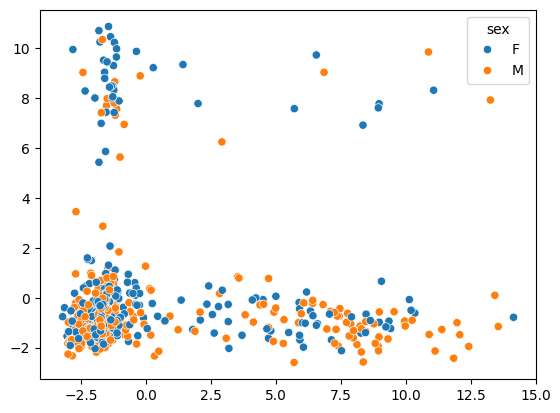

In [18]:
scaler = PCA(2)
# scaler = umap.UMAP(2)
scaler.fit(
    RobustScaler().fit_transform(data_train.drop(columns='sex').values)
    )
pca_train = scaler.transform(
    RobustScaler().fit_transform(data_train.drop(columns='sex').values)
    )
sns.scatterplot(x=pca_train[:,0], y=pca_train[:,1], hue=data_train['sex'])



In [19]:
adata[:, data_research.columns[0]].var_keys

NameError: name 'adata' is not defined

<Axes: >

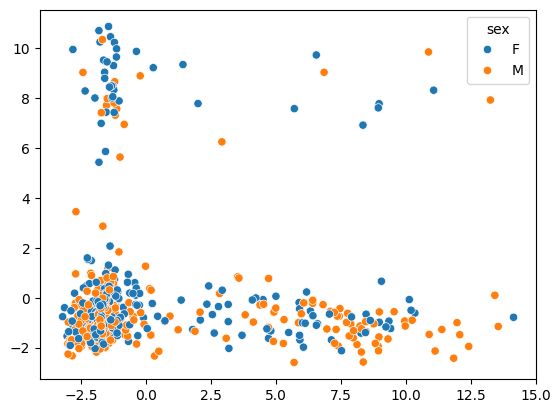

In [ ]:
scaler = PCA(2)
# scaler = umap.UMAP(2)
scaler.fit(
    RobustScaler().fit_transform(data_train.drop(columns='sex').values)
    )
pca_train = scaler.transform(
    RobustScaler().fit_transform(data_train.drop(columns='sex').values)
    )
sns.scatterplot(x=pca_train[:,0], y=pca_train[:,1], hue=data_train['sex'])



In [ ]:
from gtfparse import read_gtf

import scanpy
import anndata


def read_geuvadis(fname_data: Path | str,
                  fname_header: Path | str,
                  fname_gtf: Path | str):
    data_raw = pd.read_csv(fname_data, index_col=0).T
    data_raw = data_raw.astype(np.float32)

    data_header = pd.read_csv(fname_header, index_col=0)

    gtf_rawdata = read_gtf(fname_gtf)
    gtf_data = gtf_rawdata.to_pandas()
    gtf_data = gtf_data.set_index('transcript_id')
    gtf_data['transcript_id'] = gtf_data.index

    gtf_data = gtf_data.drop_duplicates("transcript_id")

    print('Dataset shape: ', data_raw.shape)

    return data_raw, data_header, gtf_data

data_raw, data_header, gtf_data = read_geuvadis(
    fdir_raw / 'Geuvadis.all.csv',
    fdir_raw / 'Geuvadis.SraRunTable.txt',
    fdir_raw / 'all_transcripts_strigtie_merged.gtf'
)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'exon_number', 'gene_name', 'ref_gene_id']


Dataset shape:  (667, 338725)


In [ ]:
data_raw = data_raw[data_research.columns.intersection(data_raw.columns)]
gtf_data = gtf_data.loc[data_raw.columns.intersection(gtf_data.index)]

adata = anndata.AnnData(data_raw)
adata.var = gtf_data
adata.obs = data_header


In [ ]:
data_research.columns[0]
adata[:, data_research.columns[0]].var

,seqname,source,feature,start,end,score,strand,frame,gene_id,exon_number,gene_name,ref_gene_id,transcript_id
MSTRG.1913.3,chr1,StringTie,transcript,111185129,111201235,1000.0,-,0,MSTRG.1913,,,,MSTRG.1913.3
